In [104]:
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from scipy import spatial

Assume that the background noise is the same throughout the image, and the vertical line has an angle of 0° (which, on 
closer inspection, is the case). 

In [65]:
def read_image(file_path, roi=None):
    """
    Read an image from a file and crop it to a region of interest (ROI).

    PARAMETERS:
        file_path (str): The path to the image file.
        roi (list): A list of four integers [x1, x2, y1, y2], specifying the 
            region of interest (default: None).

    RETURNS:
        array: The cropped image.
    """

    # Read the image
    image = cv.imread(file_path, 0)

    # Crop the image to the region of interest
    if roi is not None:
        image = image[roi[2]:roi[3], roi[0]:roi[1]]

    return image
    

def read_image_series(directory, prefix=None, roi=None):
    """
    Read a series of images from a directory and crop them to a region of interest (ROI).
    
    PARAMETERS:
        directory (str): The path to the directory containing the images.
        prefix (str): A common prefix for the image files (default: None).
        roi (list): A list of four integers [x1, x2, z1, z2], specifying the 
            region of interest (default: None).
            
    RETURNS:
        list: A list of cropped images.
    """
    
    # Get a list of all files in the directory
    files = os.listdir(directory)
    
    # If a prefix is specified, filter the list of files
    if prefix is not None:
        files = [f for f in files if f.startswith(prefix)]
        
    # Sort the list of files
    files.sort()
    
    # Read the images and store them in a list
    images = [read_image(os.path.join(directory, f), roi) for f in files]
    
    return images, files

In [ ]:
def all_distances(x, y=None):
    """Calculate the distance between all points in a 2D (x,y) space

    PARAMETERS:
        x (np.array): The x-coordinates of the points
        y (np.array): The y-coordinates of the points

    RETURNS:
        distances_px (np.array): The distances between all points
    """
    
    # If only one array is given, assume the other one contains only zeros
    if y is None:
        y = np.zeros_like(x)
    
    # Combine the x and y coordinates into a single array
    xy = np.column_stack([x, y])

    # Calculate the distance between all points
    distances = spatial.distance.cdist(xy, xy, 'euclidean')

    return distances

In [98]:
def weighted_avg_and_std(values, weights, mask_diagonal=True,
                         verbose=False, precision=6, units="mm/px"):
    """
    Calculate the weighted average and standard deviation of a set of values.

    PARAMETERS:
        values (array-like): The values for which to calculate the weighted 
            average and standard deviation.
        weights (array-like): The weights corresponding to each value.
        mask_diagonal (bool): Whether to mask the diagonal of the
            distance matrix (default: True).
        verbose (bool): Whether to print the results (default: False).
        precision (int): The number of decimal places to round the results 
            to (default: 5).
        units (str): The units of the values (default: "mm/px").

    RETURNS:
        tuple: A tuple containing the weighted average and standard deviation.
    """

    # Mask the diagonal to avoid division by zero
    if mask_diagonal: mask = np.eye(values.shape[0], dtype=bool).__invert__()
    else: mask = np.ones_like(values, dtype=bool)

    # Calculate the weighted average
    average = np.average(values[mask], weights=weights[mask])

    # Calculate the weighted variance and standard deviation
    variance = np.average((values[mask] - average) ** 2, weights=weights[mask])
    deviation = np.sqrt(variance)
    
    if verbose:
        print(f"The average resolution is {average:.{precision}f} {units},")
        print(f"with a standard deviation of {np.sqrt(variance):.{precision}f}"
              f" {units} ({100 * deviation / average:.{precision-2}} %).")

    # Output the average and standard deviation
    return average, deviation

In [ ]:
def intensity_peaks(profile, method='weighted_avg', threshold=85):
    """
    Find the peaks in an intensity profile.
    
    PARAMETERS:
        profile (array-like): The intensity profile.
        method (str): The method to use for peak detection (default: 'weighted_avg').
        threshold (float): The threshold for peak detection (default: 85).
        
    RETURNS:
        array: The indices of the peaks in the profile.
    """
    
    # METHOD #1: WEIGHTED INTENSITY AVERAGE
    if method == 'weighted_avg':

        # For each z coordinate...
        peak_indices = []; peak_intensities = []; current_group = []
        for idx in range(len(profile)):
            
            # Check whether the current row is above the threshold
            if profile[idx] > threshold:
                
                # If so, append the row number to the list of peak indices
                current_group.append(idx)
            else:
                
                # If not, check whether this is the end of a peak
                if len(current_group) > 0:
                    # Calculate the average intensity
                    peak_intensities.append(np.mean(profile[current_group]))
                    
                    # Calculate an average peak coordinate, weighed by the intensity 
                    peak_indices.append(
                            np.dot(profile[current_group], current_group) / 
                            np.sum(profile[current_group]))
                    
                    # Reset the current peak group
                    current_group = []
                    
    # Throw error if wrong method is specified
    else:
        raise ValueError(f"Unknown method '{method}'")
    
    # Return the (subpixel precision) indices of the peaks and their intensities
    return peak_indices, peak_intensities

In [92]:
def calibrate_camera(image, calib_dist, threshold, units="mm/px", plot=False, 
                     verbose=False, precision=3, file_name=None):
    """
    Calibrate the resolution of a camera using a calibration image.
    
    PARAMETERS:
        image (array-like): The calibration image.
        calib_dist (float): The known distance between the peaks in the image.
        threshold (float): The threshold for peak detection.
        units (str): The units of the resolution (default: "mm/px").
        plot (bool): Whether to plot the results (default: False).
        verbose (bool): Whether to print the results (default: False).
        precision (int): The number of decimal places to round the results to 
            (default: 3).
            
    RETURNS:
        tuple: A tuple containing the average resolution and standard deviation.
    """
    
    # Average all pixels in the x-direction to get the intensity profile
    int_profile = np.mean(image, axis=1)
    
    # Calculate the peaks in the intensity profile
    peak_px, peak_intensities = intensity_peaks(int_profile, 
                                                    threshold=threshold)

    # Calculate the distances between all peaks
    dist_px = all_distances(peak_px)
    
    # Define an array of distances in real units and calculate all distances
    peak_re = calib_dist * np.arange(0, len(peak_px))
    dist_re = all_distances(peak_re)
    
    # Ignoring division by zero... 
    with np.errstate(divide='ignore', invalid='ignore'):
        # ...calculate the resolutions of the image in units length per pixel
        res_matrix = dist_re / dist_px
        
    # Calculate the weighted average and standard deviation of the resolutions
    res_avg, res_std = weighted_avg_and_std(res_matrix, dist_px, 
                                            verbose=verbose, units=units,
                                            precision=precision)

    # Plot the cropped image and intensity profile side-by-side
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(6, 9))
        
        # Use file name to generate figure title
        if file_name is not None:
            fig.suptitle(file_name)
        
        # Plot the cropped image
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Calibration (cropped)')
        ax[0].set_xlabel('x [px]'); ax[0].set_ylabel('z [px]')
        
        # Plot the intensity profile
        ax[1].plot(int_profile, np.arange(0, len(int_profile)), '.')
        ax[1].set_title('Intensity profile')
        ax[1].set_xlabel('|I| (a.u.)')
        
        # Plot the intensity peaks
        ax[1].plot(peak_intensities, peak_px, 'rx')
        
        # Add a vertical line for the threshold
        ax[1].axvline(threshold, color='r', linestyle='--')
        
        # Flip and scale the profile axis to match the image
        ax[1].invert_yaxis(); ax[1].set_ylim([len(int_profile), 0])
        
        # Add an extra vertical axis on the right containing the values in mm
        ax2 = ax[1].twinx(); ax2.set_ylabel('z [m]')
        ax2.invert_yaxis(); ax2.set_ylim([len(int_profile) * res_avg/1000, 0])
        
        # Add legend
        ax[1].legend(['Mean intensity', 'Avg. peaks', 'Threshold'])
        plt.show()
        
    return res_avg, res_std

In [96]:
def calibrate_cameras(directory, roi, calib_dist, threshold, 
                      file_prefix='Calibration', units="mm/px",
                      precision=3, plot=None, verbose=False):
    """
    
    """

    # Read the calibration images in grayscale [z, x]
    calib_imgs, files = read_image_series(directory,
                                          prefix=file_prefix, roi=roi)
    no_imgs = len(calib_imgs)
    
    # Generate an array of plot flags
    if plot is True: plot = np.ones(no_imgs, dtype=bool)
    elif plot is False: plot = np.zeros(no_imgs, dtype=bool)
    elif isinstance(plot, (list, tuple, np.ndarray)):
        plot = np.array(plot, dtype=bool)
    else: raise ValueError("Invalid value for 'plot'")
    
    # For each calibration image...
    res_avg, res_std = np.zeros(no_imgs), np.zeros(no_imgs)
    for idx, calib_image in enumerate(calib_imgs):
        
        # Get the average resolution and standard deviation
        res_avg[idx], res_std[idx] = calibrate_camera(calib_image, calib_dist, 
                                             threshold, 
                                            units=units, precision=precision,
                                            plot=plot[idx], verbose=verbose,
                                            file_name=files[idx])
        
    # Compare the resolutions of the different calibration images
    # TODO: Figure out how to compare the resolutions of the different images
    
    return res_avg, res_std


The average resolution is 4.889 mm/px,
with a standard deviation of 0.002 mm/px (0.04 %).


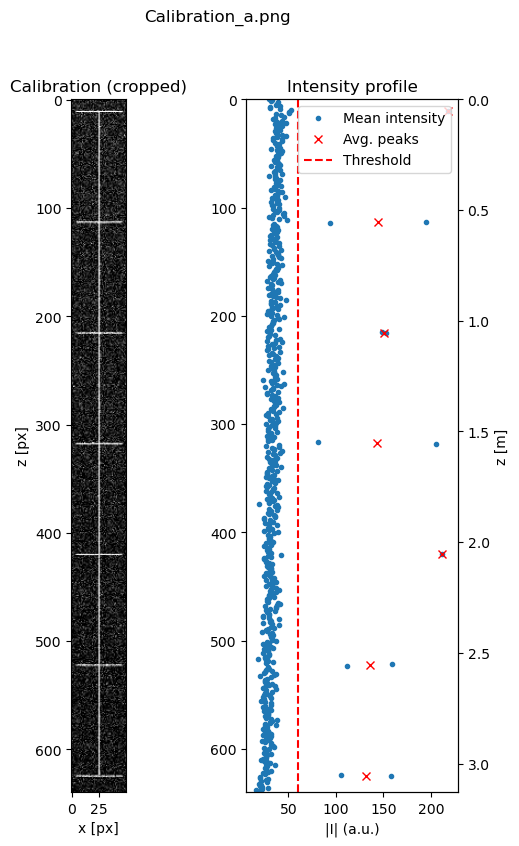

The average resolution is 4.889 mm/px,
with a standard deviation of 0.002 mm/px (0.03 %).


In [97]:
res_avg, res_std = calibrate_cameras('PTV', [200, 250, 30, 670], 500, 60, 
                                     file_prefix='Calibration_', verbose= True,
                                     plot=[True, False])

test


The average resolution is 4.889 mm/px,
with a standard deviation of 0.002 mm/px (0.04 %).


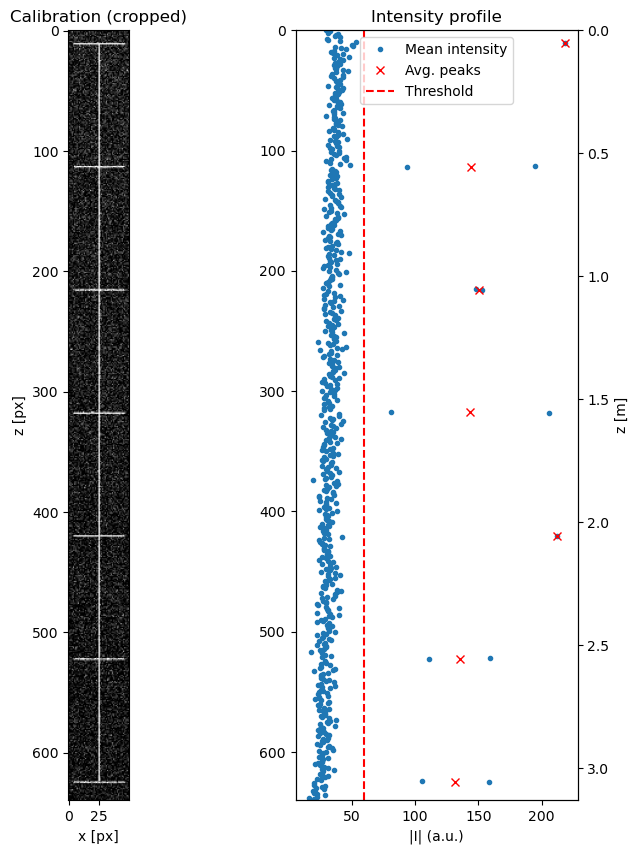

In [60]:


calib_images = read_image_series('PTV', prefix='Calibration_b',
                                 roi=[200, 250, 30, 670])

res_avg_list, res_std_list = calibrate_camera(calib_images[0], 500, 60, 
                                            plot=True, 
                               verbose=True)


Pixel centres do not matter, is just half a pixel offset.

We kunnen nog Gaussians fitten!